# Plate scale III.1: fit star YZ plate scale polynomial coefficients using sherpa

This updates the plate scale III notebook to include the rotation angle of star pairs relative to the current
flight calibration in the optimization.  The original work using purely the relative star pair distances
introduced a substantial roll change of up to 500 arcsec (at 35 C) in the plate scale.

Only the temperature-dependent terms are updated.

### Proposed new plate scale CALDB values for `fd_y_star` and `fd_z_star`:
```
array([[  7.73513457e-03,  -6.15288643e-03],
       [  2.28668273e-06,   1.38775294e-03],
       [ -1.38764910e-03,   2.56622570e-06],
       [  0.00000000e+00,   0.00000000e+00],
       [ -3.82229443e-10,   6.73615941e-10],
       [ -3.05429237e-10,   1.26847499e-09],
       [ -8.08320910e-11,  -3.87108301e-08],
       [ -1.72460168e-09,   3.48433477e-10],
       [  4.29962199e-08,  -3.27306360e-08],
       [  0.00000000e+00,   0.00000000e+00],
       [  1.52372188e-13,  -3.35659348e-11],
       [  3.25013419e-11,  -9.24719963e-14],
       [  3.29594707e-12,  -1.45179658e-12],
       [ -4.09086386e-14,  -3.26006583e-11],
       [ -1.46631936e-12,  -1.67374079e-12],
       [  1.43836757e-11,  -8.59453828e-11],
       [  3.29480263e-11,  -9.39471279e-14],
       [ -1.06374263e-12,   2.72769004e-12],
       [ -1.07588258e-10,   1.09572473e-09],
       [  0.00000000e+00,   0.00000000e+00]], dtype=float32)
```

#### Relative change: new / current values (nan is 0/0):
```
array([[ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [        nan,         nan],
       [ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [-0.03817119,  1.10892427],
       [ 1.        ,  1.        ],
       [ 1.10149503,  0.93663615],
       [        nan,         nan],
       [ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [ 1.11027324,  0.55839574],
       [ 1.        ,  1.        ],
       [ 2.06109619,  0.9242565 ],
       [-0.10917953,  0.21807756],
       [ 1.        ,  1.        ],
       [ 1.0344317 ,  0.94563287],
       [-0.76472992,  0.88378423],
       [        nan,         nan]], dtype=float32)
```

### Plate scale polynomial definition
```
 0 [ones,  
 1 c,     
 2 r, 
 3 t,  <!! Leave at 0
 4 c * c, 
 5 c * r,  
 6 c * t,  <= Temperature
 7 r * r, 
 8 r * t,  <= Temperature
 9 t * t,  <!! Leave at 0
10 c * c * c, 
11 r * c * c,
12 t * c * c,  <= Temperature
13 c * r * r, 
14 c * r * t,  <= Temperature
15 c * t * t,  <= Temperature
16 r * r * r, 
17 t * r * r,  <= Temperature
18 r * t * t,  <= Temperature
19 t * t * t]  <!! Leave at 0
```

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('bmh')
import chandra_aca.transform
from Ska.Matplotlib import plot_cxctime
from pathlib import Path
import os

from astropy.table import Table
from sherpa import ui

from plate_scale_helpers import (dist, pixels_to_yagzag, yagzag_to_pixels,
                                 get_obs_dist, compare_coeffs_dashboard)

In [2]:
pairs = Table.read('star_pairs.fits')

In [3]:
pairs[:3]

<Table length=3>
obsid     t_aca         tstart    ...      row2          col2     
int64    float64       float64    ...    float64       float64    
----- ------------- ------------- ... ------------- --------------
 2519 14.2348555073 162519980.317 ... 434.308332221 -353.132588534
 2519 14.2348555073 162519980.317 ... -474.75678961  124.474358154
 2519 14.2348555073 162519980.317 ... -474.75678961  124.474358154

In [4]:
# pairs = pairs[::3]
len(pairs)

8945

In [5]:
def dist(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [6]:
# Slimmed down version of code in chandra_aca.transform that requires
# passing in the coefficients.

def pixels_to_yagzag(row, col, coeff, t_aca=20):
    """
    Convert ACA row/column positions to ACA y-angle, z-angle.
    It is expected that the row and column input arguments have the same length.

    The ``pix_zero_loc`` parameter controls whether the input pixel values
    are assumed to have integral values at the pixel center or at the pixel
    lower/left edge.  The PEA flight coefficients assume lower/left edge, and
    that is the default.  However, it is generally more convenient when doing
    centroids and other manipulations to use the center.

    :param row: ACA pixel row (single value, list, or 1-d numpy array)
    :param col: ACA pixel column (single value, list, or 1-d numpy array)
    :param coeffs: 19 x 2 array of transform coefficients
    :param t_aca: ACA temperature (degC) for use with flight (default=20C)
    :param pix_zero_loc: row/col coords are integral at 'edge' or 'center'
    :rtype: (yang, zang) each vector of the same length as row/col
    """
    from chandra_aca.transform import _poly_convert
    
    row = np.asarray(row)
    col = np.asarray(col)

    ydeg, zdeg = _poly_convert(row, col, coeff, t_aca)

    # Convert to arcsecs from degrees
    return 3600 * ydeg, 3600 * zdeg

In [7]:
# Field distortion coefficients CALDB file aka "flight" calibration
fdc_file = Path(os.environ['SKA'], 'ops', 'CALDB', 'data', 'chandra', 
                'pcad', 'fdc', 'acapD1999-07-22fdcN0003.fits')
fdc = Table.read(fdc_file)

In [8]:
# Flight coefficients have different pixel_zero_location than on-board, so fix here.
# Chandra_aca.pixels_to_yagzag requires the following adjustment.  I don't precisely
# understand why the zag term is -2.5 instead of +2.5 but this works.
coeffs_caldb = np.array([fdc['fd_y_star'][0], fdc['fd_z_star'][0]]).transpose()
coeffs_caldb[0, :] += [2.5 / 3600, -2.5 / 3600]
coeffs_caldb = coeffs_caldb[:19]

In [9]:
# Low-order coefficients in current ground calibration
coeffs_caldb[:6, :] * 3600

array([[  3.03464851e+01,  -2.46503906e+01],
       [  8.23205803e-03,   4.99591064e+00],
       [ -4.99553680e+00,   9.23841260e-03],
       [  0.00000000e+00,   0.00000000e+00],
       [ -1.37602603e-06,   2.42501733e-06],
       [ -1.09954522e-06,   4.56651014e-06]], dtype=float32)

In [10]:
# Compare to low-order flight coeffs in EEPROM
coeffs_pea = np.rad2deg(chandra_aca.transform.PIX2ACA_eeprom)
coeffs_pea[:6, :] * 3600

array([[  3.03464844e+01,  -2.46503906e+01],
       [  9.38110352e-03,   4.99642792e+00],
       [ -4.99528198e+00,   9.14611816e-03],
       [  0.00000000e+00,   0.00000000e+00],
       [ -1.14440918e-06,   2.53915787e-06],
       [ -1.19805336e-06,   3.72529030e-06]])

In [11]:
# Add the rotation angle in arcmin for the vector connecting stars 1 and 2 using the current
# flight calibration.
yag1, zag1 = pixels_to_yagzag(pairs['row1'], pairs['col1'], coeff=coeffs_caldb, t_aca=pairs['t_aca'])
yag2, zag2 = pixels_to_yagzag(pairs['row2'], pairs['col2'], coeff=coeffs_caldb, t_aca=pairs['t_aca'])
pairs['angle_flt'] = np.rad2deg(np.arctan2(yag2 - yag1, zag2 - zag1)) * 60

In [12]:
def get_obs_dist(pairs, coeffs=coeffs_caldb):
    yag1, zag1 = pixels_to_yagzag(pairs['row1'], pairs['col1'], coeffs, t_aca=pairs['t_aca'])
    yag2, zag2 = pixels_to_yagzag(pairs['row2'], pairs['col2'], coeffs, t_aca=pairs['t_aca'])
    return dist(yag1, zag1, yag2, zag2)

In [13]:
RC_SCALE = 10000
T_SCALE = 100

In [14]:
def dist_angle_model(pars, x):
    coeff = np.asarray(pars).reshape(19, 2)
    yag1, zag1 = pixels_to_yagzag(pairs['row1'] / RC_SCALE, pairs['col1'] / RC_SCALE, coeff, 
                                  t_aca=pairs['t_aca'] / T_SCALE)
    yag2, zag2 = pixels_to_yagzag(pairs['row2'] / RC_SCALE, pairs['col2'] / RC_SCALE, coeff, 
                                  t_aca=pairs['t_aca'] / T_SCALE)
    obs_dist = dist(yag1, zag1, yag2, zag2)
    obs_angle = np.rad2deg(np.arctan2(yag2 - yag1, zag2 - zag1)) * 60  # arcmin
    return np.concatenate([obs_dist, obs_angle])

In [15]:
def get_coeffs(mdl):
    parvals = [par.val for par in mdl.pars]
    out = np.array(parvals).reshape(19, 2) / scale_coeffs()
    return out

In [16]:
def scale_coeffs():
    """Scaling to convert from nominal input units of pixels, degC to
    pixel/10000 and t/100.  This makes coefficients closer to order(1)
    and improves fitting.
    """
    r = RC_SCALE
    c = RC_SCALE
    t = T_SCALE
    scale = [1.0,  
            c,     
            r, 
            t, 
            c * c, 
            c * r,  
            c * t,
            r * r, 
            r * t,
            t * t, 
            c * c * c, 
            r * c * c,
            t * c * c,
            c * r * r, 
            c * r * t,
            c * t * t,
            r * r * r, 
            t * r * r,
            r * t * t]

    out = np.array([scale, scale]).transpose()
    return out

In [17]:
def plot_dist_resid_vs_t_aca(coeffs, title):
    obs_dist = get_obs_dist(pairs, coeffs)
    resid = pairs['yz_dist'] - obs_dist
    warm = pairs['t_aca'] > 27
    rms_warm = np.sqrt(np.mean(resid[warm]**2))
    plt.plot(pairs['t_aca'], resid, '.')
    plt.title(f'{title}: RMS error above 27C: {rms_warm:.2f} arcsec')
    plt.xlabel('ACA housing temperature')
    plt.ylabel('Star pair distance residual (arcsec)')
    plt.ylim(-1, 1.5);

In [18]:
def plot_star_pairs_residuals_flight_fit(mdl_ref):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plot_dist_resid_vs_t_aca(coeffs_caldb, 'CALDB')
    plt.subplot(1, 2, 2)
    plot_dist_resid_vs_t_aca(get_coeffs(mdl_ref), 'New fit');

In [19]:
def setup_fit(coeffs=coeffs_caldb, thaw_pars=('y2', 'z1')):
    parnames = [f'{yz}{idx}' for idx in range(19) for yz in ('y', 'z')]

    y_vals = np.concatenate([pairs['yz_dist'], pairs['angle_flt']])
    ui.load_arrays(1, np.arange(len(y_vals)), y_vals)
    ui.load_user_model(dist_angle_model, "mdl")
    ui.add_user_pars("mdl", parnames)
    ui.set_model(1, "mdl")
    ui.set_method('simplex')
    ui.set_staterror(1, 0.26)
    mdl = ui.get_model(1)

    for parname, parval in zip(parnames, (coeffs * scale_coeffs()).flatten()):
        setattr(mdl, parname, parval)
        getattr(mdl, parname).freeze()
        
    for parname in thaw_pars:
        getattr(mdl, parname).thaw()
        
    return mdl

In [20]:
t_par_idxs = [6, 8, 12, 14, 15, 17, 18]
t_parnames = [f'{yz}{idx}' for yz in ('y', 'z') for idx in t_par_idxs]
mdl_t = setup_fit(thaw_pars=t_parnames)
ui.fit()

Dataset               = 1
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 11425.5
Final fit statistic   = 7835.22 at function evaluation 8529
Data points           = 17890
Degrees of freedom    = 17876
Probability [Q-value] = 1
Reduced statistic     = 0.43831
Change in statistic   = 3590.32
   mdl.y6         -8.08321e-05
   mdl.z6         -0.0387108  
   mdl.y8         0.0429962   
   mdl.z8         -0.0327306  
   mdl.y12        0.0329595   
   mdl.z12        -0.014518   
   mdl.y14        -0.0146632  
   mdl.z14        -0.0167374  
   mdl.y15        0.00143837  
   mdl.z15        -0.00859454 
   mdl.y17        -0.0106374  
   mdl.z17        0.0272769   
   mdl.y18        -0.0107588  
   mdl.z18        0.109572    


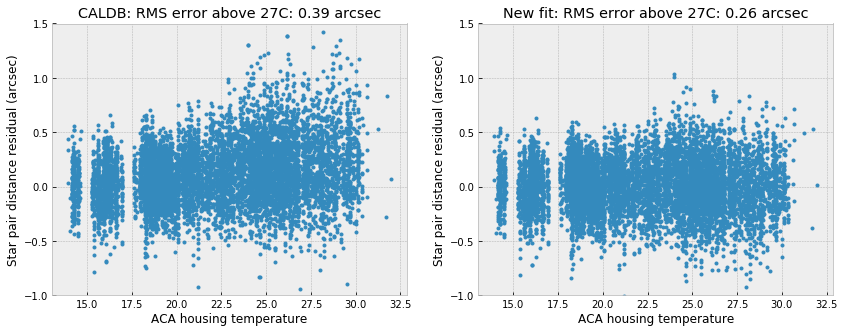

In [21]:
plot_star_pairs_residuals_flight_fit(mdl_t)

In [22]:
coeffs_fit_t = get_coeffs(mdl_t)

In [23]:
t_par_idxs = [1, 2, 4, 5, 7, 10, 11, 13, 16]
t_parnames = [f'{yz}{idx}' for yz in ('y', 'z') for idx in t_par_idxs]
mdl_all = setup_fit(thaw_pars=t_parnames, coeffs=coeffs_fit_t)
ui.fit()

Dataset               = 1
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 7835.22
Final fit statistic   = 7738.94 at function evaluation 7487
Data points           = 17890
Degrees of freedom    = 17872
Probability [Q-value] = 1
Reduced statistic     = 0.433021
Change in statistic   = 96.2776
   mdl.y1         0.0228006   
   mdl.z1         13.8777     
   mdl.y2         -13.8767    
   mdl.z2         0.0257564   
   mdl.y4         -0.0381504  
   mdl.z4         0.067281    
   mdl.y5         -0.0304813  
   mdl.z5         0.1266      
   mdl.y7         -0.1723     
   mdl.z7         0.0346027   
   mdl.y10        0.142814    
   mdl.z10        -33.6323    
   mdl.y11        32.5725     
   mdl.z11        -0.162256   
   mdl.y13        0.0572762   
   mdl.z13        -32.6998    
   mdl.y16        33.0713     
   mdl.z16        -0.11881    


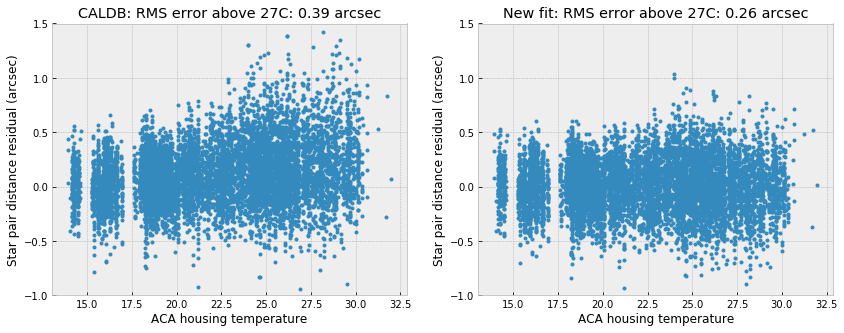

In [24]:
plot_star_pairs_residuals_flight_fit(mdl_all)

In [128]:
coeffs_mdl = get_coeffs(mdl_t)

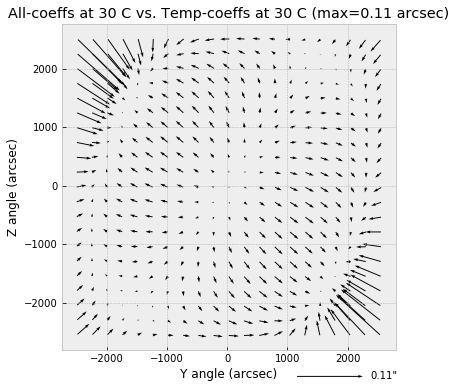

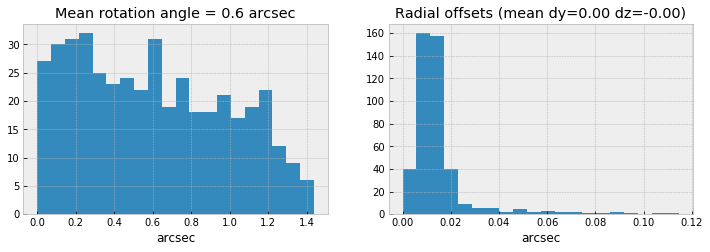

In [129]:
compare_coeffs_dashboard(coeffs1=get_coeffs(mdl_t), coeffs2=get_coeffs(mdl_all), 
                         t_aca1=30, t_aca2=30,
                         label1='Temp-coeffs', label2='All-coeffs')

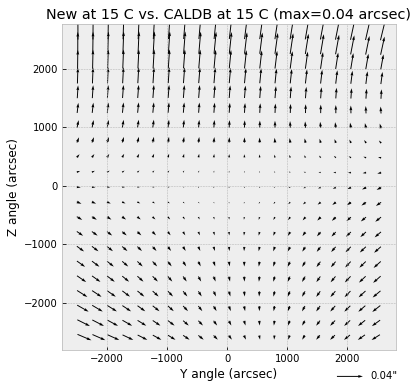

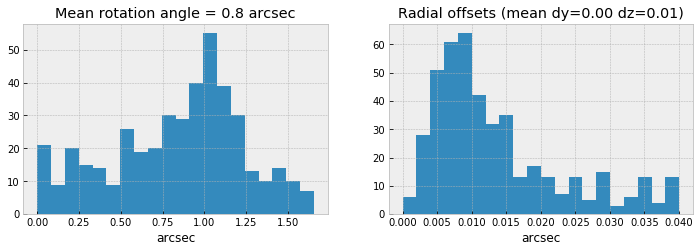

In [133]:
compare_coeffs_dashboard(coeffs1=coeffs_caldb, coeffs2=coeffs_mdl, t_aca1=15, t_aca2=15)

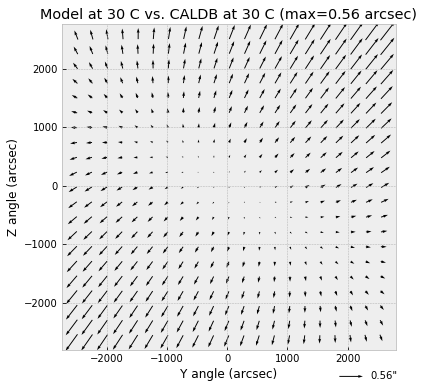

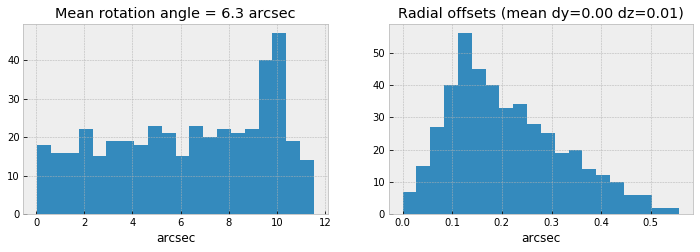

In [134]:
compare_coeffs_dashboard(coeffs1=coeffs_caldb, coeffs2=coeffs_mdl, t_aca1=30, t_aca2=30,
                        label1='CALDB', label2='Model')

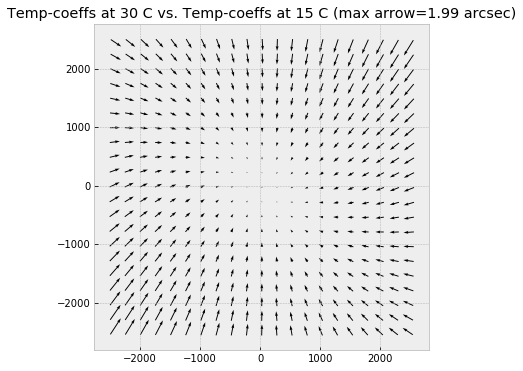

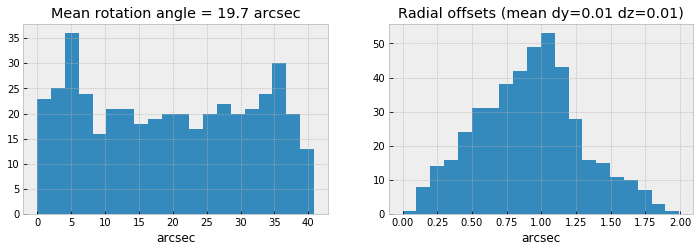

In [85]:
compare_coeffs_dashboard(coeffs1=get_coeffs(mdl_t), coeffs2=get_coeffs(mdl_t), 
                         t_aca1=15, t_aca2=30,
                         label1='Temp-coeffs', label2='Temp-coeffs')

In [81]:
coeffs_mdl

array([[  8.42957944e-03,  -6.84733083e-03],
       [  2.28668273e-06,   1.38775294e-03],
       [ -1.38764910e-03,   2.56622570e-06],
       [  0.00000000e+00,   0.00000000e+00],
       [ -3.82229443e-10,   6.73615941e-10],
       [ -3.05429237e-10,   1.26847499e-09],
       [ -8.08320902e-11,  -3.87108289e-08],
       [ -1.72460168e-09,   3.48433477e-10],
       [  4.29962197e-08,  -3.27306346e-08],
       [  0.00000000e+00,   0.00000000e+00],
       [  1.52372188e-13,  -3.35659348e-11],
       [  3.25013419e-11,  -9.24719963e-14],
       [  3.29594704e-12,  -1.45179660e-12],
       [ -4.09086386e-14,  -3.26006583e-11],
       [ -1.46631941e-12,  -1.67374074e-12],
       [  1.43836754e-11,  -8.59453813e-11],
       [  3.29480263e-11,  -9.39471279e-14],
       [ -1.06374265e-12,   2.72769013e-12],
       [ -1.07588256e-10,   1.09572478e-09]])

In [ ]:
# Slimmed down version of code in chandra_aca.transform that requires
# passing in the coefficients.

def yagzag_to_pixels(yang, zang, coeff, t_aca=20):
    """
    Convert ACA y-angle/z-angle positions to ACA pixel row, column.
    It is expected that the y-angle/z-angle input arguments have the same length.

    The ``pix_zero_loc`` parameter controls whether the input pixel values
    are assumed to have integral values at the pixel center or at the pixel
    lower/left edge.  The PEA flight coefficients assume lower/left edge, and
    that is the default.  However, it is generally more convenient when doing
    centroids and other manipulations to use ``pix_zero_loc='center'``.

    :param yang: ACA y-angle (single value, list, or 1-d numpy array)
    :param zang: ACA z-angle (single value, list, or 1-d numpy array)
    :param allow_bad: boolean switch.  If true, method will not throw errors
                         if the resulting row/col values are nominally off the ACA CCD.
    :param pix_zero_loc: row/col coords are integral at 'edge' or 'center'
    :rtype: (row, col) each vector of the same length as row/col    
    """
    from chandra_aca.transform import _poly_convert
    
    yang = np.array(yang)
    zang = np.array(zang)
    row, col = _poly_convert(yang, zang, coeff, t_aca=t_aca)

    return row, col

In [32]:
# New plate-scale coefficients in degrees
# Note, see below that fitting the rest of the non-temperature plate scale coefficients makes
# no difference at the 0.1 arcsec level, so don't bother with that in the update.
coeffs_caldb_orig = np.array([fdc['fd_y_star'][0], fdc['fd_z_star'][0]]).transpose()
coeffs_caldb_new = coeffs_caldb_orig.copy()
coeffs_caldb_new[1:19] = get_coeffs(mdl_t)[1:19]

In [33]:
coeffs_caldb_new

array([[  7.73513457e-03,  -6.15288643e-03],
       [  2.28668273e-06,   1.38775294e-03],
       [ -1.38764910e-03,   2.56622570e-06],
       [  0.00000000e+00,   0.00000000e+00],
       [ -3.82229443e-10,   6.73615941e-10],
       [ -3.05429237e-10,   1.26847499e-09],
       [ -8.08320910e-11,  -3.87108301e-08],
       [ -1.72460168e-09,   3.48433477e-10],
       [  4.29962199e-08,  -3.27306360e-08],
       [  0.00000000e+00,   0.00000000e+00],
       [  1.52372188e-13,  -3.35659348e-11],
       [  3.25013419e-11,  -9.24719963e-14],
       [  3.29594707e-12,  -1.45179658e-12],
       [ -4.09086386e-14,  -3.26006583e-11],
       [ -1.46631936e-12,  -1.67374079e-12],
       [  1.43836757e-11,  -8.59453828e-11],
       [  3.29480263e-11,  -9.39471279e-14],
       [ -1.06374263e-12,   2.72769004e-12],
       [ -1.07588258e-10,   1.09572473e-09],
       [  0.00000000e+00,   0.00000000e+00]], dtype=float32)

In [34]:
# Current flight plate-scale coefficients
coeffs_caldb_new / coeffs_caldb_orig

array([[ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [        nan,         nan],
       [ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [-0.03817119,  1.10892427],
       [ 1.        ,  1.        ],
       [ 1.10149503,  0.93663615],
       [        nan,         nan],
       [ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [ 1.11027324,  0.55839574],
       [ 1.        ,  1.        ],
       [ 2.06109619,  0.9242565 ],
       [-0.10917953,  0.21807756],
       [ 1.        ,  1.        ],
       [ 1.0344317 ,  0.94563287],
       [-0.76472992,  0.88378423],
       [        nan,         nan]], dtype=float32)

### PEA centroid yag/zag errors for obsid 47523

https://icxc.cfa.harvard.edu/aspect/centroid_dashboard//47/47523/index.html 

In [82]:
dat = fetch.Msid('aach1t', '2020:021:06:00:00', '2020:021:06:30:00', stat='5min')
dat.vals

array([ 33.09725952,  33.09725952,  33.09725952,  33.09725952,  33.09725952], dtype=float32)

In [83]:
yang =1978
zang =2318
row, col = chandra_aca.transform.yagzag_to_pixels(yang, zang)

In [74]:
y1, z1 = pixels_to_yagzag(row, col, coeff=coeffs_pea, t_aca=10)
y2, z2 = pixels_to_yagzag(row, col, coeff=coeffs_mdl, t_aca=33.1)

In [75]:
y1 - y2, z1 - z2

(1.745866113129523, 2.4498696371392725)

In [52]:
from cheta import fetch_sci as fetch

In [77]:
dat = fetch.Msid('aach1t', '2010:001', stat='5min')

In [78]:
%matplotlib inline

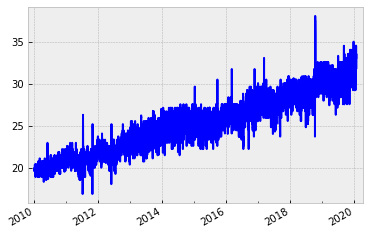

In [79]:
dat.plot()

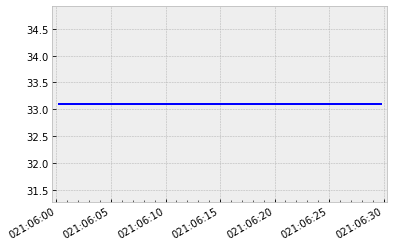

In [59]:
dat.plot()

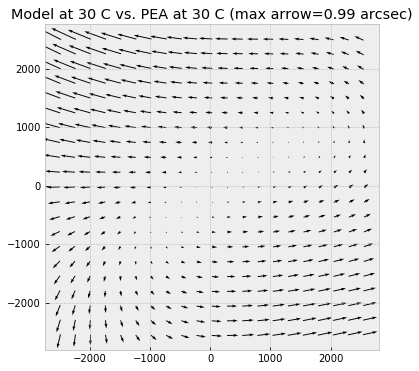

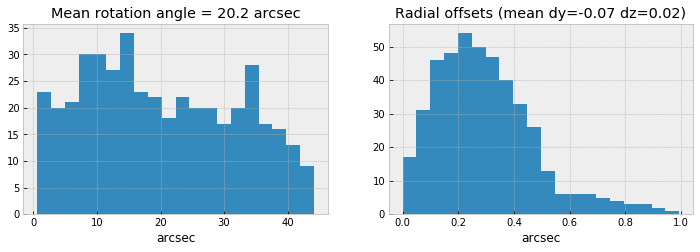

In [45]:
compare_coeffs_dashboard(coeffs1=coeffs_pea, t_aca1=30, coeffs2=coeffs_mdl, t_aca2=30, 
                         label1='PEA', label2='Model')

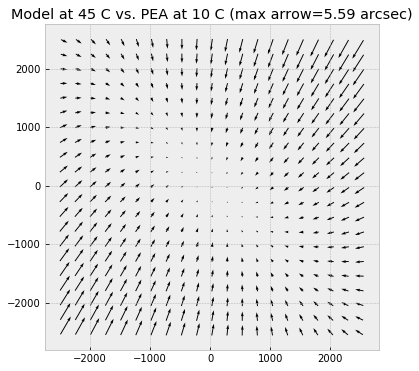

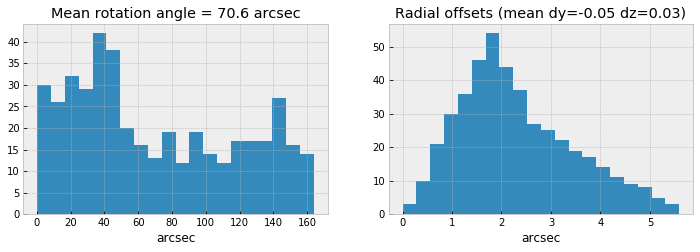

In [80]:
# Predicted peak ACA housing temperature in 2027 is around 45 C.
compare_coeffs_dashboard(coeffs1=coeffs_pea, t_aca1=10, coeffs2=coeffs_mdl, t_aca2=45, 
                         label1='PEA', label2='Model')

In [57]:
fetch.content['AACH1T']

'pcad5eng'

In [76]:
fetch.Msid?